## Introduction to DICOM and basic preprocessing

In this notebook, we will explore two common medical imaging file formats: **DICOM (Digital Imaging and Communications in Medicine)** This format is widely used in clinical and research environments respectively.

The main objectives of this module are:
- Understanding DICOM Files
- Basic Image Visualization 
- Basic Preprocessing and Image Quality Assessment

### 1. Introduction to DICOM Files

#### What is a DICOM File?
[DICOM](https://www.dicomstandard.org/) (Digital Imaging and COmmunications in Medicine) is the de-facto standard that establishes rules that allow medical images (X-Ray, MRI, CT) and associated information to be exchanged between imaging equipment from different vendors, computers, and hospitals. It not only stores the image but also includes important metadata such as patient details, modality (e.g., CT, MRI), image orientation, pixel spacing, and much more. The DICOM format provides a suitable means that meets health information exchange (HIE) standards for transmission of health related data among facilities and HL7 standards which is the messaging standard that enables clinical applications to exchange data.

DICOM files typically have a .dcm extension and provides a means of storing data in separate ‘tags’ such as patient information, image/pixel data, the machine used, etc.

For more information, refer to : https://www.dicomstandard.org/about-home

#### Use Cases:
- **DICOM** is heavily used in hospitals and clinics because it integrates with medical imaging equipment.
- **Clinical Metadata**: DICOM files include vital information about the patient and imaging modality, which is essential for diagnosis and treatment.

#### Structure of a DICOM File
A typical DICOM file contains:
- **Header**: Contains metadata such as patient ID, modality, and image acquisition details.
- **Image Data**: The pixel data representing the actual image.

#### Load and read a DICOM image


The following package supports working with DICOM files:

- [pydicom](https://pydicom.github.io/) is a dedicated library for handling DICOM files, allowing access to both pixel data and the associated metadata (e.g., patient details, equipment information, scan parameters). pydicom is ideal when working in medical contexts where you need to inspect, modify, or extract specific information from the DICOM headers in addition to the image data. `pydicom` is best for comprehensive access to both image and metadata, useful when medical details are required for further analysis. It provides pixel data as a NumPy array via the pixel_array attribute, which can be processed and visualized easily. `pydicom` is commonly used with `numpy` and `matplotlib`. `numpy` provides a flexible and efficient structure (the NumPy array) to store and manipulate image data across all three libraries (imageio, pydicom, and scipy.ndimage) and `matplotlib.pyplot` is used to visualize the image data after it's loaded and processed, displaying it in an intuitive and customizable way.


When working with DICOM files, they may sometimes be compressed into a .zip archive. To handle this, we first need to unzip the files before reading them. This can be done easily using Python's `zipfile` module to unzip the DICOM file, or you can unzip the file using the GUI.

To read the image, using the `pydicom` library use the `dcmread()` function, which gives you access to the pixel data via the pixel_array attribute.

In [15]:
import zipfile
import os
# Path to the zip file and the directory where the contents will be extracted
zip_file_path = '/path/to/your/dicom_files.zip'
extract_dir = '/path/to/extract/'

# Check if the zip file exists
if os.path.exists(zip_file_path):
    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extracted files to {extract_dir}")
    
    # List the contents of the extracted folder
    extracted_files = os.listdir(extract_dir)
    print("Extracted DICOM files:")
    for file in extracted_files:
        print(file)
else:
    print(f"Zip file not found: {zip_file_path}")

# Directory containing your DICOM files
dicom_dir = '/path/to/extracted/DICOM/files'

Zip file not found: /path/to/your/dicom_files.zip


In [16]:
#Load required libraries
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

In [17]:
# Load a DICOM file

file_path = "DICOM/IM-0004-0060.dcm"
dicom_file = pydicom.dcmread(file_path)

#### Read Metadata

Metadata refers to supplementary information that describes or provides context for the primary data, such as images or documents. In the context of medical imaging, metadata includes details about how, when, and with what equipment an image was acquired. This might involve information such as the date of the scan, scanner settings, patient demographics (excluding personally identifiable information if anonymized), and details about the imaging modality.
Since this scan was acquired for research purposes, the "patient" information does not contain personally-identifying information like the name or birth. date of the person who was scanned.

In [18]:
print(dicom_file)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 198
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.176.3596.7771172.7255.1265293350.441
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.5.4
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_354'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.840.113619.2.176.3596.7771172.7255.1265293350.441
(0008,0020) Study Date                          DA: 

In DICOM files, metadata is organized into various elements. These elements store both the image data and essential metadata. 
The print output shows a list of the data elements (or elements for short) present in the dataset, one element per line. The format of each line is:

- `(0008, 0005)`: The element’s tag, as (group number, element number) in hexadecimal

- `Specific Character Set`: the element’s name, if known

- `CS`: The element’s Value Representation (VR), if known

- `‘ISO_IR_100’`: the element’s stored value

There are three main categories of DICOM elements:

- **Standard Elements**: Defined in the DICOM standard, have even group numbers, and store common metadata.
    
    Example:

        `(0008,0016)` - SOP Class UID
        `(0008,0020)` - Study Date
- **Repeating Group Elements**: Allow multiple occurrences at the same level, with group numbers in a range.

    Example:

        `(60xx,3000)` - Overlay Data (where xx can be 0x6000, 0x6002, 0x6004, etc., up to 0x601E).

- **Private Elements**: Created by manufacturers, have odd group numbers, and can store vendor-specific data. 

    Example:

         `(0043,104E)` - [Duration of X-ray on] (Private Element)




This structure allows DICOM to be highly extensible, accommodating both standardized and vendor-specific data. You can explore these elements using pydicom to retrieve both standard and custom metadata from medical images.

In pydicom, you can access all of these elements and their values directly from the DICOM object.

You can access DICOM elements in several ways:

1. **By attribute name** (if the element is part of the DICOM standard):
   ```python
   dicom_file.PatientName
   dicom_file.StudyDate
   ```

2. **By tag** (using hexadecimal notation):
   ```python
   dicom_file[0x0010, 0x0010]  # Patient Name
   dicom_file[0x0008, 0x0020]  # Study Date
   ```

3. **Using string tag format**:
   ```python
   dicom_file['0010', '0010']
   ```

Let's explore some common DICOM elements:

In [19]:
# Extract and print metadata

# Helper function to safely get DICOM attribute
def get_dicom_attr(dicom_obj, attr_name, default="Not available"):
    """Safely retrieve a DICOM attribute, return default if not present"""
    try:
        value = getattr(dicom_obj, attr_name, None)
        return value if value is not None else default
    except:
        return default

# Access standard DICOM elements by attribute name
print("=== Patient Information ===")
print(f"Patient Name: {get_dicom_attr(dicom_file, 'PatientName')}")
print(f"Patient ID: {get_dicom_attr(dicom_file, 'PatientID')}")
print(f"Patient Birth Date: {get_dicom_attr(dicom_file, 'PatientBirthDate')}")
print(f"Patient Sex: {get_dicom_attr(dicom_file, 'PatientSex')}")

print("\n=== Study Information ===")
print(f"Study Date: {get_dicom_attr(dicom_file, 'StudyDate')}")
print(f"Study Time: {get_dicom_attr(dicom_file, 'StudyTime')}")
print(f"Study Description: {get_dicom_attr(dicom_file, 'StudyDescription')}")
print(f"Study ID: {get_dicom_attr(dicom_file, 'StudyID')}")

print("\n=== Series Information ===")
print(f"Modality: {get_dicom_attr(dicom_file, 'Modality')}")
print(f"Series Number: {get_dicom_attr(dicom_file, 'SeriesNumber')}")
print(f"Series Description: {get_dicom_attr(dicom_file, 'SeriesDescription')}")

print("\n=== Image Information ===")
print(f"Image Type: {get_dicom_attr(dicom_file, 'ImageType')}")
print(f"Rows: {get_dicom_attr(dicom_file, 'Rows')}")
print(f"Columns: {get_dicom_attr(dicom_file, 'Columns')}")
print(f"Pixel Spacing: {get_dicom_attr(dicom_file, 'PixelSpacing')}")
print(f"Slice Thickness: {get_dicom_attr(dicom_file, 'SliceThickness')}")
print(f"Slice Location: {get_dicom_attr(dicom_file, 'SliceLocation')}")

print("\n=== Equipment Information ===")
print(f"Manufacturer: {get_dicom_attr(dicom_file, 'Manufacturer')}")
print(f"Manufacturer Model Name: {get_dicom_attr(dicom_file, 'ManufacturerModelName')}")
print(f"Magnetic Field Strength: {get_dicom_attr(dicom_file, 'MagneticFieldStrength')}")

# Access elements by tag (hexadecimal notation)
print("\n=== Accessing by Tag ===")
try:
    print(f"SOP Class UID [0008,0016]: {dicom_file[0x0008, 0x0016].value}")
except:
    print(f"SOP Class UID [0008,0016]: Not available")

try:
    print(f"Instance Number [0020,0013]: {dicom_file[0x0020, 0x0013].value}")
except:
    print(f"Instance Number [0020,0013]: Not available")

# Check if a specific element exists before accessing it
if hasattr(dicom_file, 'ImageComments'):
    print(f"\nImage Comments: {dicom_file.ImageComments}")
else:
    print("\nImage Comments: Not available")

=== Patient Information ===
Patient Name: AARONTEST
Patient ID: AARONTEST
Patient Birth Date: 
Patient Sex: M

=== Study Information ===
Study Date: 20100204
Study Time: 201859
Study Description: Not available
Study ID: 14415

=== Series Information ===
Modality: MR
Series Number: 4
Series Description: SAG 3D T1 SPGR

=== Image Information ===
Image Type: ['ORIGINAL', 'PRIMARY', 'OTHER']
Rows: 256
Columns: 256
Pixel Spacing: [1, 1]
Slice Thickness: 1
Slice Location: -34.39938354

=== Equipment Information ===
Manufacturer: GE MEDICAL SYSTEMS
Manufacturer Model Name: SIGNA EXCITE
Magnetic Field Strength: 1.5

=== Accessing by Tag ===
SOP Class UID [0008,0016]: 1.2.840.10008.5.1.4.1.1.4
Instance Number [0020,0013]: 60

Image Comments: Not available


The `pydicom` library allows you to access the image's pixel data stored in the DICOM file using the pixel_array attribute. This data represents the raw pixel intensity values of the medical image, which can be visualized using libraries like matplotlib.

In the following code, we use pydicom to read the DICOM file and extract the pixel data. We then use matplotlib to display the image in grayscale, which is common for medical images such as X-rays, CT scans, and MRIs.

In [20]:
# Extract pixel data
dicom_image = dicom_file.pixel_array

# Print the DICOM image as a NumPy array
print("DICOM Image as a NumPy Array:")
print(dicom_image)

DICOM Image as a NumPy Array:
[[ 0  0  0 ... 11  8  3]
 [ 0  0  0 ...  4  5  7]
 [ 0  0  0 ...  9  9 10]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [21]:
# Print the dimensions of the DICOM image
print(f"Image shape (dimensions): {dicom_image.shape}")
print(f"Dimensions: {dicom_image.shape[0]} x {dicom_image.shape[1]} pixels")

# You can also print some statistics for better readability
# min_pixel, max_pixel and mean_pixel values
print(f"\nPixel Statistics:")
print(f"Min pixel value: {dicom_image.min()}")
print(f"Max pixel value: {dicom_image.max()}")
print(f"Mean pixel value: {dicom_image.mean():.2f}")
print(f"Data type: {dicom_image.dtype}")

Image shape (dimensions): (256, 256)
Dimensions: 256 x 256 pixels

Pixel Statistics:
Min pixel value: 0
Max pixel value: 6536
Mean pixel value: 1258.96
Data type: int16


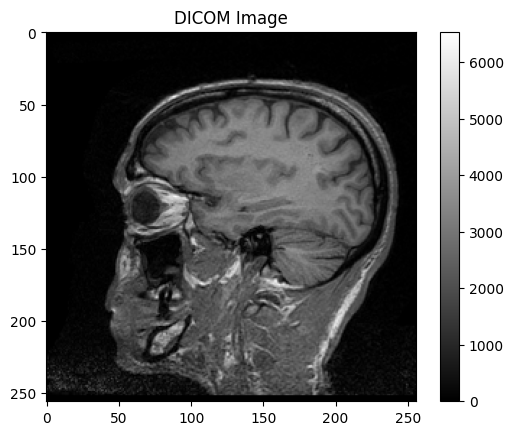

In [22]:
# Visualize the DICOM image
plt.imshow(dicom_image, cmap='gray')
plt.title('DICOM Image')
plt.colorbar()
plt.show()

The metadata and pixel information has been extracted here for a single .dcm file. We can also index the multiple .dcm files we extracted and perform the same functions as:

Brain volume shape: (184, 256, 256)
Number of slices: 184
Slice dimensions: 256 x 256

First slice statistics:
Min pixel value: 0
Max pixel value: 2150
Mean pixel value: 62.03


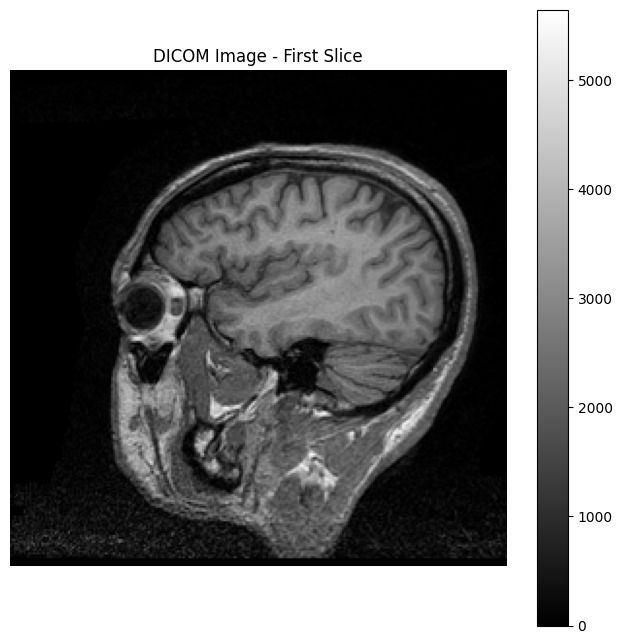

In [23]:
# Define the DICOM directory
dicom_dir = "DICOM"

# Get all DICOM files in the directory
dicom_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')]

# Sort files by instance number or another DICOM attribute if required
dicom_files.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)

# Initialize a list to store all slices
brain_slices = []

# Read each DICOM file and store the pixel data in the brain_slices list
for dicom_file_path in dicom_files:
    dicom_slice = pydicom.dcmread(dicom_file_path)
    brain_slices.append(dicom_slice.pixel_array)

# Convert to a NumPy array for easier manipulation (optional)
brain_slices = np.array(brain_slices)

# Now you can access each slice like brain_slices[0], brain_slices[1], etc.
# Print the shape (dimensions) of the brain_slices array
print(f"Brain volume shape: {brain_slices.shape}")
print(f"Number of slices: {brain_slices.shape[0]}")
print(f"Slice dimensions: {brain_slices.shape[1]} x {brain_slices.shape[2]}")

# Print the pixel array of the first slice (brain_slices[0])
print(f"\nFirst slice statistics:")
print(f"Min pixel value: {brain_slices[0].min()}")
print(f"Max pixel value: {brain_slices[0].max()}")
print(f"Mean pixel value: {brain_slices[0].mean():.2f}")

# Visualize the first DICOM slice
plt.figure(figsize=(8, 8))
plt.imshow(brain_slices[130], cmap='gray')
plt.title('DICOM Image - First Slice')
plt.colorbar()
plt.axis('off')
plt.show()

Unlike the 0-255 pixel intensity range in standard images, MRI scans in DICOM format store pixel values that represent signal intensities. MRI images capture different contrasts based on tissue properties (e.g., T1-weighted, T2-weighted, etc.), and these signal intensities can vary widely depending on the type of sequence and scan parameters. Pixel values can range from 0 to very high values (7000-9000 as above), depending on the scanning modality, resolution, and what part of the body is being imaged.

```
[[ 0  0  0 ...  8  5  2]
 [ 0  0  0 ...  6  0  5]
 [ 0  0  0 ... 17 24  5]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
```
This array represents the raw pixel intensity values of the DICOM slice, where:

- 0 typically represents the background or areas outside the brain, where no signal is detected.
- Higher values represent areas with higher signal intensity, which may correlate with different tissue types or abnormalities (depending on the MRI modality).

The output pixel statistics for slice [0] represents:

- Min pixel value (0): This is common for regions outside the tissue, like air or background.
- Max pixel value (7017): This could correspond to areas of high signal intensity, such as regions with strong MRI signals like blood vessels or contrast-enhanced regions.
- Mean pixel value (1246.57): This gives you an idea of the overall signal intensity of the slice, indicating the average brightness across the slice.

The reason for such values, in comaprison to the traditional 0-255 range we deal with for standard image formats (JPEG, PNG, etc.) is because these formats use 8-bit per channel color depth. These values represent the intensity of each pixel for grayscale images or the intensity of each color channel (red, green, blue) in color images.

In medical images, particularly in formats like DICOM or NIfTI, pixel values represent more than just simple intensity. They often carry information about the tissue characteristics, physical properties (like density or radiodensity), or signal intensities from imaging machines like CT or MRI. These values are stored in floating-point or higher-bit integers to capture a wider dynamic range of intensities, which is essential for accurate diagnosis. 

MRI scanners store signal intensities using 12-bit or 16-bit depth, which means that pixel values can exceed the 255 range of standard images, allowing for much higher precision in intensity values. In this case, the maximum pixel value of 7017 is quite typical for high-resolution medical images, particularly in MRI.
The full range of pixel values might not always be directly useful for visualization. In clinical practice, radiologists use windowing techniques to adjust the display of these pixel values to fit the display range (e.g., 0-255), highlighting specific tissues of interest. However, for data analysis, usually we work with the raw pixel values (like in an array), which preserve the full dynamic range of the MRI scan. 

The non-normalized image displayed perfectly suggests that the DICOM image already contains pixel values in an appropriate range for visualization. Commonly, DICOM files include fields like `RescaleSlope` and `RescaleIntercept`, which transform raw pixel values into a more meaningful range (e.g., Hounsfield units for CT scans). MRI scans often have pixel intensities that map to tissue types or structures in the body, so forcing them into a 0-255 range can remove useful information.

#### Visualize a slice through different planes

Since the data are a 3D NumPy array, it is very easy to "reslice" the image and visualize the head from one of the other two orientations, axial and coronal. Below we pass `:` to select all sagittal slices, and `128` for the second dimension to get the slice midway through the volume, in the axial plane. Again, we omit the third dimension and so `:` is assumed:

Volume shape: (184, 256, 256)
Volume dimensions: 184 slices x 256 rows x 256 columns

Middle slice indices:
Axial (Z-axis): 92
Coronal (Y-axis): 128
Sagittal (X-axis): 128


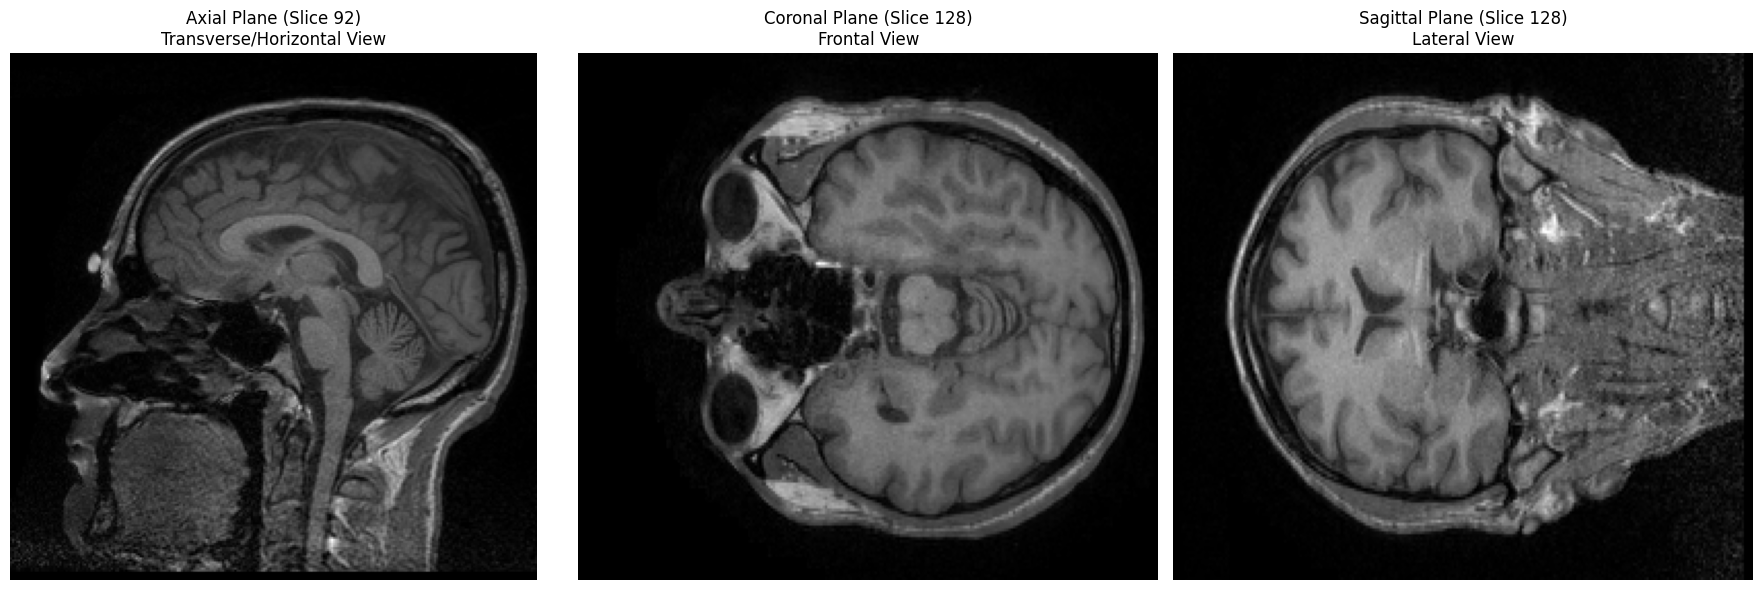


Volume Statistics:
Min pixel value: 0
Max pixel value: 8847
Mean pixel value: 801.38
Data type: int16


In [24]:
# Function to load DICOM volume
def load_dicom_volume(dicom_dir):
    """
    Load all DICOM files from a directory and stack them into a 3D volume
    """
    slices = []
    dicom_files = []
    
    # Get all DICOM files
    for filename in sorted(os.listdir(dicom_dir)):
        if filename.endswith('.dcm'):
            filepath = os.path.join(dicom_dir, filename)
            dicom_files.append(filepath)
    
    # Sort by instance number to ensure correct ordering
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)
    
    # Read each DICOM file and extract pixel data
    for filepath in dicom_files:
        ds = pydicom.dcmread(filepath)
        slices.append(ds.pixel_array)
    
    # Stack slices into a 3D volume
    volume = np.stack(slices, axis=0)
    
    return volume

# Load the volume
volume = load_dicom_volume(dicom_dir)

# Ensure the volume has the expected dimensions
print(f"Volume shape: {volume.shape}")
print(f"Volume dimensions: {volume.shape[0]} slices x {volume.shape[1]} rows x {volume.shape[2]} columns")

# Determine middle slices for each plane
mid_axial = volume.shape[0] // 2      # Middle slice along Z-axis (axial plane)
mid_coronal = volume.shape[1] // 2    # Middle slice along Y-axis (coronal plane)
mid_sagittal = volume.shape[2] // 2   # Middle slice along X-axis (sagittal plane)

print(f"\nMiddle slice indices:")
print(f"Axial (Z-axis): {mid_axial}")
print(f"Coronal (Y-axis): {mid_coronal}")
print(f"Sagittal (X-axis): {mid_sagittal}")

# Extract slices for each plane
axial_slice = volume[mid_axial, :, :]           # Horizontal slice (top view)
coronal_slice = volume[:, mid_coronal, :]       # Front view
sagittal_slice = volume[:, :, mid_sagittal]     # Side view

# Plotting the three anatomical planes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting Axial Plane (Z-axis slices) - Horizontal/Transverse view
axes[0].imshow(axial_slice, cmap='gray')
axes[0].set_title(f'Axial Plane (Slice {mid_axial})\nTransverse/Horizontal View')
axes[0].axis('off')
axes[0].set_xlabel('Left ← → Right')
axes[0].set_ylabel('Posterior ← → Anterior')

# Plotting Coronal Plane (Y-axis slices) - Front view
axes[1].imshow(coronal_slice, cmap='gray', aspect='auto')
axes[1].set_title(f'Coronal Plane (Slice {mid_coronal})\nFrontal View')
axes[1].axis('off')
axes[1].set_xlabel('Left ← → Right')
axes[1].set_ylabel('Inferior ← → Superior')

# Plotting Sagittal Plane (X-axis slices) - Side view
axes[2].imshow(sagittal_slice, cmap='gray', aspect='auto')
axes[2].set_title(f'Sagittal Plane (Slice {mid_sagittal})\nLateral View')
axes[2].axis('off')
axes[2].set_xlabel('Posterior ← → Anterior')
axes[2].set_ylabel('Inferior ← → Superior')

plt.tight_layout()
plt.show()

# Display volume statistics
print(f"\nVolume Statistics:")
print(f"Min pixel value: {volume.min()}")
print(f"Max pixel value: {volume.max()}")
print(f"Mean pixel value: {volume.mean():.2f}")
print(f"Data type: {volume.dtype}")

#### Plotting an image histogram

As we saw above, the image is stored as a NumPy array, in which each voxel in the image is represented as a number, which is mapped to an intensity value in the colourmap when plotting. Larger values appear as brighter (whiter), and lower values appear as darker.

Histograms of the anatomical images show the number of voxels of a given intensity value. These can be informative because the distribution of intensity values in an anatomical image is not uniform. Instead, as we can see above, there are many very dark voxels (outside of the head, and in some of the fluid-filled spaces inside the head), and then clusters of voxels that are darker grey (the grey matter, largely in the cerebral cortex that forms the outer layer of the brain), lighter grey (the white matter that comprises much of the inside of the brain), and also some very bright areas that are primarily due to areas of fat concentration.

We can use NumPy's `histogram()` function along with matplotlib to plot a histogram of our brain volume. For 3D volumes, we need to flatten the array first. This function requires several arguments, including the range (minimum and maximum intensity values) and the number of bins:

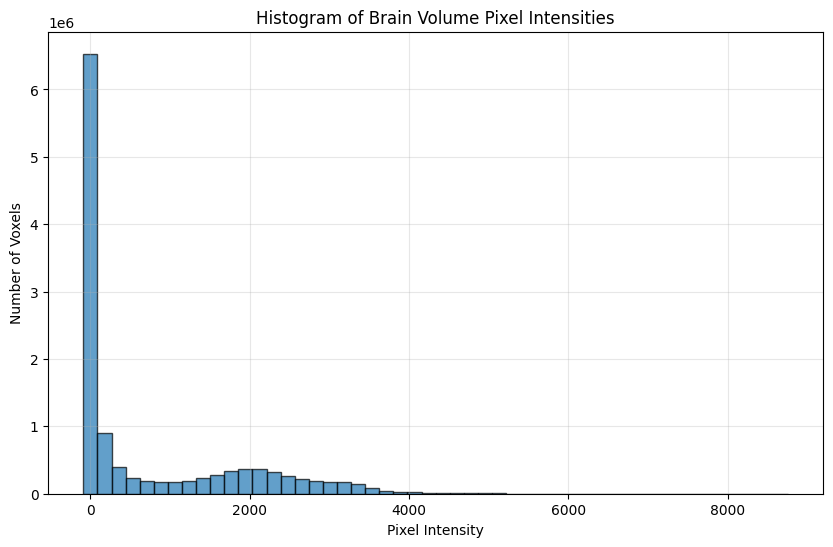

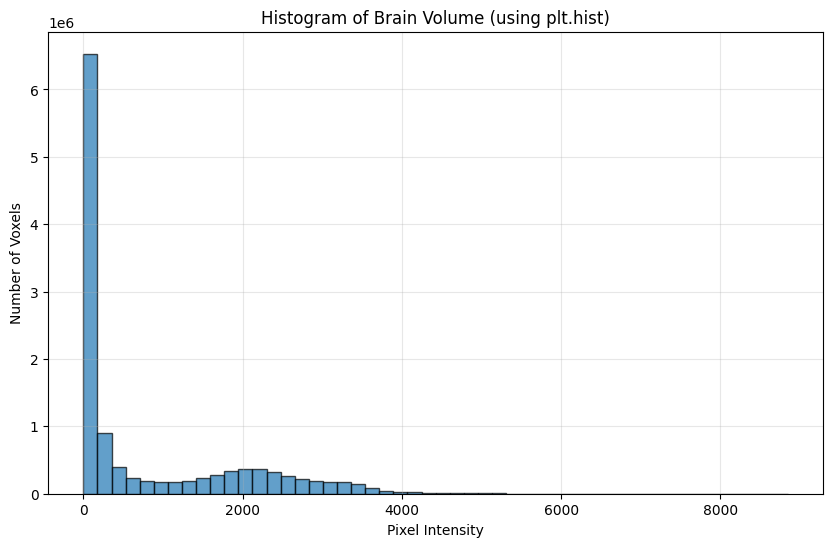

In [26]:
# Plot the histogram

# Flatten the volume to 1D array for histogram calculation
volume_flat = volume.flatten()

# Calculate histogram
hist, bins = np.histogram(volume_flat, bins=50, range=(volume.min(), volume.max()))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], hist, width=np.diff(bins), edgecolor='black', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Voxels')
plt.title('Histogram of Brain Volume Pixel Intensities')
plt.grid(True, alpha=0.3)
plt.show()

# Alternative: Using matplotlib's hist function directly
plt.figure(figsize=(10, 6))
plt.hist(volume_flat, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Voxels')
plt.title('Histogram of Brain Volume (using plt.hist)')
plt.grid(True, alpha=0.3)
plt.show()

In the histogram above, there is a large peak close to zero which represents the fact that a large number of voxels in the image don't contain the head at all, and therefore have values at or close to zero. We can see a peak just above 10 on the *x* axis (note that the numbers on the *x* axis are bin numbers, not intensity values), with a slight decrease and then a second small peak just before 20, followed by a flat area. The peaks just above 10 and just below 20 reflect the concentration of similar intensity values corresponding to grey and white matter respectively. 

### Basic Preprocessing and Image Quality Assessment

There are several image quality measurements that are commonly used in medical image analysis to assess the quality of an image, These include metrics that evaluate noise, contrast, sharpness, and overall fidelity of the image. Some key image quality metrics that can be included are:


1. **Signal-to-Noise Ratio (SNR)**: SNR measures the amount of signal present in an image compared to the noise. Higher SNR values indicate clearer images with less noise. The SNR can be calculated by dividing the mean pixel intensity of the signal by the standard deviation of the background (noise).
2. **Contrast-to-Noise Ratio (CNR)**: CNR is similar to SNR but evaluates the contrast between two regions of interest, making it useful for comparing different tissues (e.g., tumor vs. normal tissue). CNR is the difference in mean intensity between two regions divided by the standard deviation of the background.
3. **Sharpness (Edge Detection)**: Sharpness can be quantified by measuring the gradient magnitude at edges in the image. Sharper edges usually correspond to better image quality. You can use methods like the Sobel or Laplacian filter to assess image sharpness.
4. **Root Mean Square Error (RMSE)**:RMSE compares the difference between the original image and a processed version of the image (e.g., after filtering or compression) to evaluate how much detail has been lost. RMSE is calculated by taking the square root of the mean squared difference between two images.

  Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- --------------------------

Signal-to-Noise Ratio (SNR): 45.00
Contrast-to-Noise Ratio (CNR): 27.33
Sharpness (Mean Gradient Magnitude): nan
Root Mean Square Error (RMSE): 363.62


C:\Users\tajan\AppData\Local\Temp\ipykernel_20216\479755864.py:68: RuntimeWarning: invalid value encountered in sqrt
  gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)


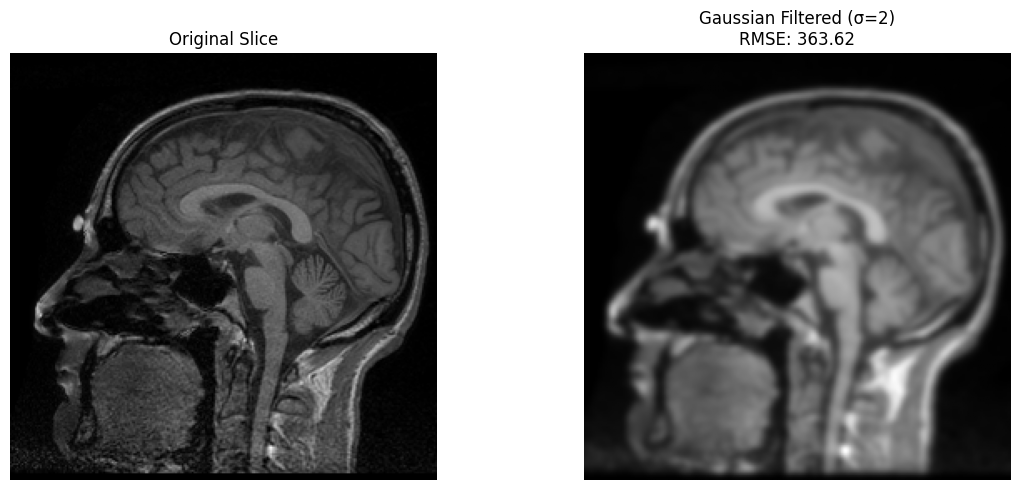


=== Image Quality Metrics Summary ===
SNR: 45.00 - Higher values indicate better signal clarity
CNR: 27.33 - Higher values indicate better contrast between tissues
Sharpness: nan - Higher values indicate sharper edges
RMSE: 363.62 - Lower values indicate less difference from original


In [37]:
%pip install scikit-learn
from scipy.ndimage import sobel, gaussian_filter
from sklearn.metrics import mean_squared_error

# Select a slice to work with (using the middle axial slice)
test_slice = volume[mid_axial, :, :]

# Define regions (adjust coordinates as needed based on your image)
# Signal region: center of the brain (example coordinates)
signal_region = test_slice[100:150, 100:150]

# Noise region: background area outside the head (example coordinates)
noise_region = test_slice[0:50, 0:50]

# Region 1 and Region 2: different tissue types for CNR
# For example, white matter vs gray matter regions
region1 = test_slice[120:140, 120:140]  # Example: white matter
region2 = test_slice[80:100, 80:100]     # Example: gray matter

# 1. Signal-to-Noise Ratio (SNR)
def calculate_snr(image_data, signal_region, noise_region):
    """
    Calculate SNR as the ratio of mean signal intensity to noise standard deviation
    """
    mean_signal = np.mean(signal_region)
    std_noise = np.std(noise_region)
    
    # Avoid division by zero
    if std_noise == 0:
        return float('inf')
    
    snr = mean_signal / std_noise
    return snr

snr_value = calculate_snr(test_slice, signal_region, noise_region)
print(f"Signal-to-Noise Ratio (SNR): {snr_value:.2f}")

# 2. Contrast-to-Noise Ratio (CNR)
def calculate_cnr(image_data, region1, region2, noise_region):
    """
    Calculate CNR as the difference in mean intensities between two regions
    divided by the noise standard deviation
    """
    mean_region1 = np.mean(region1)
    mean_region2 = np.mean(region2)
    std_noise = np.std(noise_region)
    
    # Avoid division by zero
    if std_noise == 0:
        return float('inf')
    
    cnr = abs(mean_region1 - mean_region2) / std_noise
    return cnr

cnr_value = calculate_cnr(test_slice, region1, region2, noise_region)
print(f"Contrast-to-Noise Ratio (CNR): {cnr_value:.2f}")

# 3. Sharpness (using Sobel edge detection)
def calculate_sharpness(image_data):
    """
    Calculate sharpness by measuring the mean gradient magnitude using Sobel filter
    """
    # Apply Sobel filter in x and y directions
    sobel_x = sobel(image_data, axis=0)
    sobel_y = sobel(image_data, axis=1)
    
    # Calculate gradient magnitude
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Mean gradient magnitude represents sharpness
    sharpness = np.mean(gradient_magnitude)
    return sharpness

sharpness_value = calculate_sharpness(test_slice)
print(f"Sharpness (Mean Gradient Magnitude): {sharpness_value:.2f}")

# 4. Root Mean Square Error (RMSE)
# Apply Gaussian filter to create a processed version of the image
processed_slice = gaussian_filter(test_slice, sigma=2)

def calculate_rmse(original_image, processed_image):
    """
    Calculate RMSE between original and processed images
    """
    # Flatten the images to 1D arrays
    original_flat = original_image.flatten()
    processed_flat = processed_image.flatten()
    
    # Calculate RMSE using sklearn
    rmse = np.sqrt(mean_squared_error(original_flat, processed_flat))
    return rmse

rmse_value = calculate_rmse(test_slice, processed_slice)
print(f"Root Mean Square Error (RMSE): {rmse_value:.2f}")

# Display the original and processed images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(test_slice, cmap='gray')
axes[0].set_title('Original Slice')
axes[0].axis('off')

axes[1].imshow(processed_slice, cmap='gray')
axes[1].set_title(f'Gaussian Filtered (σ=2)\nRMSE: {rmse_value:.2f}')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Summary of image quality metrics
print("\n=== Image Quality Metrics Summary ===")
print(f"SNR: {snr_value:.2f} - Higher values indicate better signal clarity")
print(f"CNR: {cnr_value:.2f} - Higher values indicate better contrast between tissues")
print(f"Sharpness: {sharpness_value:.2f} - Higher values indicate sharper edges")
print(f"RMSE: {rmse_value:.2f} - Lower values indicate less difference from original")

### Coding Project - Simple Brain Region Segmentation from DICOM Images

In this project, you will work only with the provided DICOM zip file.
Your goal is to perform a simple segmentation of one region of the brain using basic image-processing tools.

You are free to choose:

* which slice to analyze,
* which plane (axial, sagittal, or coronal),
* which segmentation method to use
  (intensity thresholding, histogram-based selection, filtering + threshold,watershed etc.).

### **Tasks**

1. Load the DICOM images

2. Inspect the metadata of at least one slice
   (e.g., SliceLocation, ImageOrientationPatient, PixelSpacing, SliceThickness).
   Use this information to briefly justify **why you selected a particular slice or plane** for segmentation.

3. Visualize the selected slice, and optionally plot its intensity histogram.

4. Choose a simple segmentation strategy to isolate a meaningful brain region
   (for example something resembling grey matter, white matter, or any visibly distinct structure).

5. Create a binary mask that isolates the region based on your chosen method.

6. Apply the mask to the slice and display the segmented region.

7. (Optional but recommended) – Basic Image Quality Measurement

To connect this project with the image-quality section of the lab, compute one of the following metrics on your chosen slice:

- SNR (Signal-to-Noise Ratio)

- CNR (Contrast-to-Noise Ratio)

- Sharpness (e.g., Sobel gradient magnitude)

- RMSE between the original slice and a filtered version (e.g., Gaussian)

A very short explanation about what your chosen metric tells you about the image is enough.

8. Write a short comment discussing:

   * what the segmentation isolates well,
   * what it fails to isolate,
   * the limitations of simple intensity-based methods.

No advanced algorithms are required.
The goal is to explore how basic DICOM information and pixel intensities can guide the segmentation of a brain region.
